In [0]:
from google.colab import drive

drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%cd /content/gdrive/My Drive/Colab Notebooks/텐서플로와 머신러닝으로 시작하는 자연어처리 PyTorch/6. 챗봇

/content/gdrive/My Drive/Colab Notebooks/텐서플로와 머신러닝으로 시작하는 자연어처리 PyTorch/6. 챗봇


In [0]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 1.4MB/s 
     |████████████████████████████████| 3.6MB 71.3MB/s 
     |████████████████████████████████| 92kB 11.3MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


## Preparing Data

In [0]:
import os

if not os.path.exists('./data_out'):
  os.makedirs('./data_out')
else:
  print("folder already exists")

import numpy as np
import json
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from configs import DEFINES

DATA_IN_PATH = './data_in/'
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIGS = 'data_configs.json'

index_inputs = np.load(open(DATA_IN_PATH + TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(DATA_IN_PATH + TRAIN_OUTPUTS , 'rb'))
index_targets = np.load(open(DATA_IN_PATH + TRAIN_TARGETS , 'rb'))

index_inputs = torch.Tensor(index_inputs).long()
index_outputs = torch.Tensor(index_outputs).long()
index_targets = torch.Tensor(index_targets).long()
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

BATCH_SIZE = DEFINES['batch_size']
EPOCHS = DEFINES['num_epochs']
MAX_SEQUENCE_LENGTH = DEFINES['max_sequence_length']
learning_rate = DEFINES['learning_rate']
dropout_rate = DEFINES['dropout_rate']
embedding_dim = DEFINES['embedding_size']
hidden_dim = DEFINES['hidden_size']
layer_size = DEFINES['layer_size']

vocab_size = prepro_configs['vocab_size']

folder already exists


In [0]:
print(index_inputs.shape, index_outputs.shape)
print(BATCH_SIZE, EPOCHS, MAX_SEQUENCE_LENGTH)
print(learning_rate, dropout_rate, embedding_dim, hidden_dim, layer_size, vocab_size)

torch.Size([10640, 25]) torch.Size([10640, 25])
64 30 25
0.001 0.5 256 1024 3 20705


In [0]:
class TrainData(Dataset):
  def __init__(self):
    self.inp = index_inputs
    self.out = index_outputs
    self.tar = index_targets

  def __getitem__(self, s):
    return self.inp[s], self.out[s], self.tar[s]

  def __len__(self):
    return self.tar.shape[0]

train_data = TrainData()
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

In [0]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


Let's denote B: batch size(64), T: max sequence length(25), N: number of layers(3), E: embedding size(256), H: hidden size(1024), V: vocab size(20705)

## Encoder

In [0]:
class Encoder(nn.Module):
  def __init__(self, vocab_size=vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim, layer_size=layer_size):
      super(Encoder, self).__init__()
      self.hidden_dim = hidden_dim
      self.layer_size = layer_size
      self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
      self.GRU = nn.GRU(input_size=embedding_dim, num_layers=layer_size, hidden_size=hidden_dim,
                        dropout=dropout_rate, batch_first=True)

  def initHidden(self, val):
      return torch.zeros(self.layer_size, val, self.hidden_dim)

  def forward(self, input, hidden):
      # input: B x T, hidden: N x B x H
      embedded = self.embedding(input)
      # embedded: B x T x  E
      output = embedded
      output, hidden = self.GRU(output, hidden)
      # output: B x T x H, hidden: N x B x H
      return output, hidden

### Encoder Testing

In [0]:
encoder = Encoder()
encoder.to(device)

Encoder(
  (embedding): Embedding(20705, 256, padding_idx=0)
  (GRU): GRU(256, 1024, num_layers=3, batch_first=True, dropout=0.5)
)

In [0]:
tmp = index_inputs[:2].to(device)
enc_hidden = encoder.initHidden(2)

print(tmp.shape, enc_hidden.shape)

torch.Size([2, 25]) torch.Size([3, 2, 1024])


In [0]:
enc_output, enc_hidden = encoder(tmp, enc_hidden)

In [0]:
print(enc_output.shape, enc_hidden.shape)

torch.Size([2, 25, 1024]) torch.Size([3, 2, 1024])


## Attention Decoder

In [0]:
class AttnDecoder(nn.Module):
  def __init__(self, vocab_size=vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim, layer_size=layer_size):
    super(AttnDecoder, self).__init__()
    self.vocab_size = vocab_size
    self.hidden_dim = hidden_dim
    self.layer_size = layer_size
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
    self.gru = nn.GRU(input_size=hidden_dim+embedding_dim, num_layers=layer_size, hidden_size=hidden_dim,
                        dropout=dropout_rate, batch_first=True)
    self.fc = nn.Linear(hidden_dim, vocab_size)
    # for attention
    self.W1 = nn.Linear(self.hidden_dim, self.hidden_dim)
    self.W2 = nn.Linear(self.hidden_dim, self.hidden_dim)
    self.V = nn.Linear(self.hidden_dim, 1)
  
  def initHidden(self, val):
      return torch.zeros(self.layer_size, val, self.hidden_dim)

  def forward(self, dec_input, dec_hidden, enc_output):
    # dec_input: B x 1, dec_hidden: N x B x H, enc_output: B x T x H
    hidden = dec_hidden[-1] # last layer, hidden: B x H
    hidden = hidden.unsqueeze(1) # hidden: B x 1 x H
    score = torch.tanh(self.W1(enc_output)+self.W2(hidden)) # score: B x T x H
    attn_weights = torch.softmax(self.V(score), dim=1) # attn_weights: B x T x 1
    context_vector = attn_weights * enc_output # context_vector: B x T x H
    context_vector = torch.sum(context_vector, dim=1) # context_vector: B x H
    
    embedded = self.embedding(dec_input) # embedded: B x 1 x E
    x = torch.cat([context_vector.unsqueeze(1), embedded], -1) # x: B x 1 x (E+H)

    output, state = self.gru(x) # output: B x 1 x H, state: N X B x H
    output = output.view(-1, output.shape[2])
    out = self.fc(output) # out: B x V
    return out, state, attn_weights

###  Decoder Testing with T=1

In [0]:
decoder = AttnDecoder()
decoder.to(device)

tmp = index_outputs[:2][:, [0]].to(device)
dec_hidden = decoder.initHidden(2)

out, dec_hidden, attn_weights = decoder(tmp, dec_hidden, enc_output)

In [0]:
print(out.shape, dec_hidden.shape, attn_weights.shape)

torch.Size([2, 20705]) torch.Size([3, 2, 1024]) torch.Size([2, 25, 1])


## Training

In [0]:
encoder = Encoder()
encoder.to(device)

decoder = AttnDecoder()
decoder.to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(list(encoder.parameters())+list(decoder.parameters()), lr=learning_rate)

In [0]:
def train(train_loader=train_loader, encoder=encoder, decoder=decoder, optimizer=optimizer, num_epochs=EPOCHS):
  encoder.train()
  decoder.train()
  total_losses = []
  losses = []

  for epoch in range(num_epochs):
    total_loss = 0
    for idx, (inp, out, target) in enumerate(train_loader):
      loss = 0
      inp, out, target = inp.to(device), out.to(device), target.to(device)
      
      enc_hidden = encoder.initHidden(inp.shape[0])
      enc_output, enc_hidden = encoder(inp, enc_hidden)

      dec_hidden = enc_hidden
      # use teacher forcing
      for ti in range(out.shape[1]):
        dec_input = (out[:, [ti]]).long()
        dec_output, dec_hidden, dec_attention = decoder(dec_input, dec_hidden, enc_output)
        loss += criterion(dec_output, dec_input.squeeze())

      loss = loss / (ti+1)
      losses.append(loss.item())
      total_loss += loss 

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if epoch % 5 ==0 and idx % 50 == 0:
        print(f"Epoch: {epoch+1}, batch: {idx+1}, loss: {loss.item()}")

    total_loss /= (len(train_data) / BATCH_SIZE)
    total_losses.append(total_loss)

    if epoch % 5 == 0:
      print(f"Epoch: {epoch+1}, Train Loss: {total_loss.item()}")

  return total_losses, losses 

In [0]:
total_losses, losses = train()

Epoch: 1, batch: 1, loss: 9.956208229064941
Epoch: 1, batch: 51, loss: 1.984777569770813
Epoch: 1, batch: 101, loss: 1.6221121549606323
Epoch: 1, batch: 151, loss: 1.646448016166687
Epoch: 1, Train Loss: 2.1542253494262695
Epoch: 6, batch: 1, loss: 0.9630067944526672
Epoch: 6, batch: 51, loss: 0.9486489295959473
Epoch: 6, batch: 101, loss: 1.069811224937439
Epoch: 6, batch: 151, loss: 0.8987990021705627
Epoch: 6, Train Loss: 0.8878481388092041
Epoch: 11, batch: 1, loss: 0.19060523808002472
Epoch: 11, batch: 51, loss: 0.18377964198589325
Epoch: 11, batch: 101, loss: 0.1857285499572754
Epoch: 11, batch: 151, loss: 0.17852634191513062
Epoch: 11, Train Loss: 0.1737940013408661
Epoch: 16, batch: 1, loss: 0.013795009814202785
Epoch: 16, batch: 51, loss: 0.008181079290807247
Epoch: 16, batch: 101, loss: 0.018039638176560402
Epoch: 16, batch: 151, loss: 0.01152808591723442
Epoch: 16, Train Loss: 0.012578935362398624
Epoch: 21, batch: 1, loss: 0.0026531207840889692
Epoch: 21, batch: 51, loss: 0

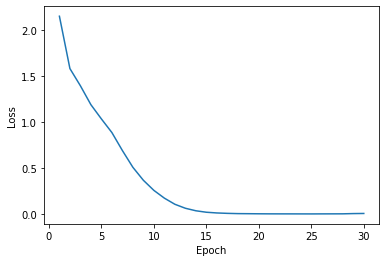

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1, 31), list(map(lambda x: x.item(), total_losses)))
plt.xlabel("Epoch")
plt.ylabel("Loss");

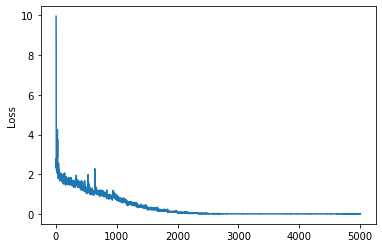

In [0]:
plt.plot(range(1, len(losses)+1), losses)
plt.ylabel("Loss");

In [0]:
torch.save(encoder.state_dict(), './seq2seq_encoder.pth')
torch.save(decoder.state_dict(), './seq2seq_decoder.pth')
  
print("Model is saved.")

Model is saved.


## Evaluation

In [0]:
encoder = Encoder()
decoder = AttnDecoder()

encoder.load_state_dict(torch.load('./seq2seq_encoder.pth'))
decoder.load_state_dict(torch.load('./seq2seq_decoder.pth'))

<All keys matched successfully>

In [0]:
VAL_INPUTS = 'val_inputs.npy'
VAL_OUTPUTS = 'val_outputs.npy'
VAL_TARGETS = 'val_targets.npy'

val_inputs = np.load(open(DATA_IN_PATH + VAL_INPUTS, 'rb'))
val_outputs = np.load(open(DATA_IN_PATH + VAL_OUTPUTS , 'rb'))
val_targets = np.load(open(DATA_IN_PATH + VAL_TARGETS , 'rb'))

val_inputs = torch.Tensor(val_inputs).long()
val_outputs = torch.Tensor(val_outputs).long()
val_targets = torch.Tensor(val_targets).long()

In [0]:
class ValData(Dataset):
  def __init__(self):
    self.inp = val_inputs
    self.out = val_outputs
    self.tar = val_targets

  def __getitem__(self, s):
    return self.inp[s], self.out[s], self.tar[s]

  def __len__(self):
    return self.tar.shape[0]

val_data = ValData()
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

In [0]:
def validate(val_loader=val_loader, encoder=encoder, decoder=decoder):
  encoder.eval()
  decoder.eval()
  loss = 0
  acc = 0

  with torch.no_grad():
    for inp, out, target in val_loader:
      inp, out, target = inp.to(device), out.to(device), target.to(device)

      enc_hidden = encoder.initHidden(inp.shape[0])
      enc_output, enc_hidden = encoder(inp, enc_hidden)

      dec_hidden = enc_hidden

      for ti in range(out.shape[1]):
        dec_input = (out[:, [ti]]).long()
        dec_output, dec_hidden, dec_attention = decoder(dec_input, dec_hidden, enc_output)
        loss += criterion(dec_output, dec_input.squeeze()).item()
        pred = torch.argmax(dec_output, dim=1)
        acc += (pred == dec_input.squeeze()).sum() / inp.shape[0]

      loss = loss / (ti+1)
      acc = acc.item() 
      
  return loss / (len(val_data) // BATCH_SIZE + 1), acc / (len(val_data) // BATCH_SIZE + 1)

In [0]:
val_loss, val_acc = validate()
print(val_loss, val_acc)

/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


0.013953658092643303 19.263157894736842


The low validation accuracy is probably due to the strict teacher forcing. <br>
This notebook is just for describing how attention mechanism in seq2seq is used.<br>
It is more desirable to drop teacher forcing ratio to 0.2~0.5 if you really want to exploit this model!